# Offline Signature Verification Program
classifying a preprocessed, labeled signature image samples using a CNN classifier.

**Uploading related files**

Uploading zip file by the help of files instance of google colab.

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving Samples.zip to Samples.zip


Unzipping the samples.zip file by the help of zipfile module.

In [ ]:
import zipfile  #module reads and writes zip files

zip_file_name = 'Samples.zip' # uploaded 'Samples.zip'

# Extract the ZIP file
with zipfile.ZipFile(zip_file_name, 'r') as zip_ref:
    zip_ref.extractall()

# Get the folder name (without the .zip extension)
folder_name = zip_file_name.replace('.zip', '')

FileNotFoundError: [Errno 2] No such file or directory: 'Samples.zip'

looking inside the samples directory by listing its the items.

In [ ]:
import os #module allows interacting with the operating system

# List files in the folder to verify
os.listdir(folder_name)

['full_forg', 'full_org']

**forming dataset**

In [ ]:
#importing important tools

import tensorflow as tf

In [ ]:
dataset_dir ='Samples'

forming the dataset using tf.keras.utils module which access the function "image_data_from_directory". It takes directory path which includes subdirectories within directory, each containing images for a particular class.
dataset variable hold the dataset "tf.data.Dataset" which is generated. It provides various methods for data manipulation, batching, shuffling, prefetching, etc.

In [ ]:
dataset = tf.keras.utils.image_dataset_from_directory(dataset_dir,color_mode='grayscale')

Found 2640 files belonging to 2 classes.


**Normalizing and binarizing dataset**

Normalizing image pixels between 0 and 1, Then binarize the image using the threshold of 0.5. Now the images pixels have only values of 1 and zero.

In [ ]:
def binarize(images, threshold):
    # Normalize the images to [0, 1]
    images = images / 255.0
    # Apply the threshold
    binary_images = tf.where(images > threshold, 1.0, 0.0)
    return binary_images

The images are binarize using maping function to map the dataset images to their binarizied ones. Labels remains the same.

The length of the data is 83 batches. 2640 images and their labels are devided into 82 batch, each batch contains 32 binarized image. The last batch contains the rest of the images(16 image).

In [ ]:
binary_dataset = dataset.map(lambda image, label: (binarize(image, 0.5),label))
len(binary_dataset)

83

Inverting the image by subtracting each image pixel from 1

In [ ]:
inverted_dataset = binary_dataset.map(lambda image, label: (image-1,label))
len(inverted_dataset)

83

 creating an iterator that yields batches from the inverted_dataset as NumPy arrays.

In [ ]:
data_iterator = inverted_dataset.as_numpy_iterator()

It takes the first batch from data_iterator. We can notice that the shape of batch is a 4 D array(size of batch, rows, columns, channels). Sample of batch content is shown below.

In [ ]:
batch= data_iterator.next()
print(len(batch))
print(batch[0].shape)
images =batch[0]
images[0].shape

2
(32, 256, 256, 1)


(256, 256, 1)

In [ ]:
print(len(images))
print(images[0])

32
[[[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 ...

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]]


An example of an original preprocessed image visualized by the help of matplotlib

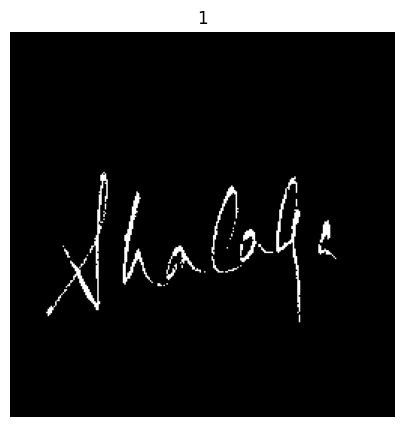

In [ ]:
import matplotlib.pyplot as plt

# Plot the first image in the batch
plt.figure(figsize=(5, 5))
plt.imshow(batch[0][0].squeeze(), cmap='gray_r')  # Use the reversed grayscale colormap
plt.title(batch[1][0])  # Set the title to the corresponding label
plt.axis('off')  # Turn off axis
plt.show()  # Display the plot

dividing the dataset into training, validation, and testing sets. The sizes of each are given below.

In [ ]:
# we added one because test_size gives zero and validation size gives 1
train_size = int(len(binary_dataset)*0.7)
validation_size = int(len(binary_dataset)*0.2)+1
test_size = int(len(binary_dataset)*0.1)
print(train_size)
print(validation_size)
print(test_size)

58
17
8


The datasets are ready now to be given to the CNN model.

In [ ]:
train = inverted_dataset.take(train_size)
validat = inverted_dataset.skip(train_size).take(validation_size)
test = inverted_dataset.skip(train_size + validation_size).take(test_size)

Import the model type and layers that will be used  to create the CNN classifier. Since there are no multiple inputs/outputs, Sequential builder api has been used. It stack layers in a linear, one-by-one fashion. It is straightforward and easy to use for models where each layer has exactly one input tensor and one output tensor.

In [ ]:
from tensorflow.keras.models import Sequential #class
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout #classes

Since images are in 2 dimetional pixel aray with one channel, The use of 2D convolutional layer is advicable.

Adds a 2D convolution layer with 16 filters, each of size 3x3, and a stride of 1. The stride of 1 means the filter moves 1 pixel at a time across the input. ReLU (Rectified Linear Unit) activation function, which only passes positive values and sets negative values to zero.



In [ ]:
#model type
cnn_model = Sequential()

#adding layer sequentially to the model, conv: 16 kernals, each is 3x3, stride of 1 pixel each time
#these all are architecture decisions
#the best architecture of a model for a specific problem: state of the art model
#relu takes the positive values only
cnn_model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,1)))
#reduced half of the data(half of the rows and half of the columns)
cnn_model.add(MaxPooling2D())

cnn_model.add(Conv2D(32, (3,3), 1, activation='relu'))
cnn_model.add(MaxPooling2D())

cnn_model.add(Conv2D(16, (3,3), 1, activation='relu'))
cnn_model.add(MaxPooling2D())

#condense the rows and columns, and the filter will form the channel value
#when we pass the output to dense, we dont want the channel value so we condense it to a single value
cnn_model.add(Flatten()) # condense multi-rank tensor to one dimension

cnn_model.add(Dense(256, activation='relu')) #256 output (weights+ bias)
cnn_model.add(Dense(1, activation='sigmoid')) # one output(zero or one)

In [ ]:
#optimizer, loss function, accuracy
cnn_model.compile('adam', loss = tf.losses.BinaryCrossentropy(), metrics = ['accuracy'])
print(cnn_model.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 254, 254, 16)      160       
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 127, 127, 16)      0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 62, 62, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 30, 30, 16)       

In [ ]:
#fit the model(train it and validate it)
#train: 4 baches, epochs: how many times to train our model over the trainset
#validation set: 17 baches
hist = cnn_model.fit(train, epochs=20, validation_data=validat)

Epoch 1/20
58/58 [==============================] - 144s 2s/step - loss: 0.5889 - accuracy: 0.6886 - val_loss: 0.4780 - val_accuracy: 0.8051
Epoch 2/20
58/58 [==============================] - 104s 2s/step - loss: 0.3931 - accuracy: 0.8319 - val_loss: 0.3836 - val_accuracy: 0.8217
Epoch 3/20
58/58 [==============================] - 102s 2s/step - loss: 0.2377 - accuracy: 0.9009 - val_loss: 0.3609 - val_accuracy: 0.8566
Epoch 4/20
58/58 [==============================] - 103s 2s/step - loss: 0.1109 - accuracy: 0.9612 - val_loss: 0.3607 - val_accuracy: 0.8750
Epoch 5/20
58/58 [==============================] - 107s 2s/step - loss: 0.0515 - accuracy: 0.9876 - val_loss: 0.8302 - val_accuracy: 0.8254
Epoch 6/20
58/58 [==============================] - 102s 2s/step - loss: 0.0339 - accuracy: 0.9925 - val_loss: 0.4407 - val_accuracy: 0.9062
Epoch 7/20
58/58 [==============================] - 104s 2s/step - loss: 0.0160 - accuracy: 0.9962 - val_loss: 0.4753 - val_accuracy: 0.9062
Epoch 8/20
58

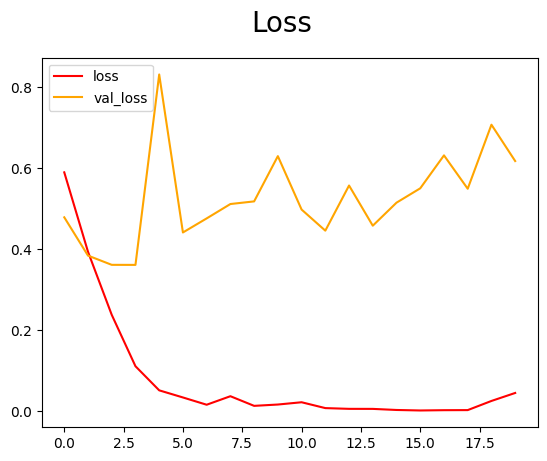

In [ ]:
import matplotlib.pyplot as plt

fig = plt.figure()
plt.plot(hist.history['loss'], color='red', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

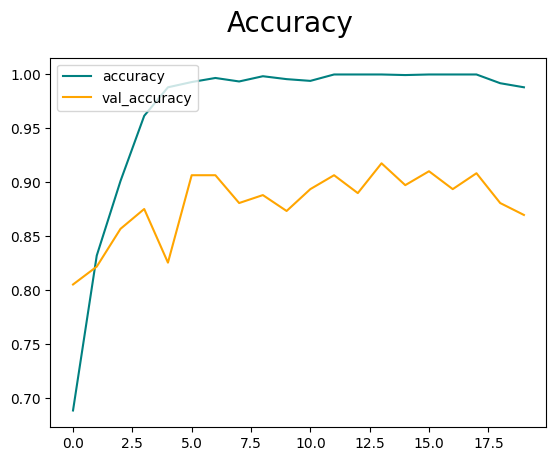

In [ ]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

In [ ]:
cnn_model_improved= Sequential()
cnn_model_improved.add(Conv2D(32, (3,3), 1, activation='relu', input_shape=(256,256,1))),
cnn_model_improved.add(MaxPooling2D((2, 2)))
cnn_model_improved.add(Dropout(0.25))  # Add dropout after the first convolutional layer

cnn_model_improved.add(Conv2D(64, (3, 3), 1, activation='relu'))
cnn_model_improved.add(MaxPooling2D((2, 2)))
cnn_model_improved.add(Dropout(0.25))  # Add dropout after the second convolutional layer

cnn_model_improved.add(Conv2D(16, (3, 3), 1, activation='relu'))
cnn_model_improved.add(MaxPooling2D((2, 2)))
cnn_model_improved.add(Dropout(0.25))  # Add dropout after the third convolutional layer

cnn_model_improved.add(Flatten())
cnn_model_improved.add(Dense(128, activation='relu'))
cnn_model_improved.add(Dropout(0.5))   # Add dropout before the output layer
cnn_model_improved.add(Dense(1, activation='sigmoid'))


In [ ]:
#optimizer, loss function, accuracy
cnn_model_improved.compile(optimizer='adam', loss = tf.losses.BinaryCrossentropy(), metrics = ['accuracy'])
print(cnn_model.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 254, 254, 16)      160       
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 127, 127, 16)      0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 62, 62, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 30, 30, 16)       

In [ ]:
#fit the model(train it and validate it)
#train: 4 baches, epochs: how many times to train our model over the trainset
#validation set: 2 baches, callbacks:
hist = cnn_model_improved.fit(train, epochs=20, validation_data=validat)

Epoch 1/20
58/58 [==============================] - 214s 4s/step - loss: 0.6169 - accuracy: 0.6595 - val_loss: 0.5463 - val_accuracy: 0.7684
Epoch 2/20
58/58 [==============================] - 213s 4s/step - loss: 0.4937 - accuracy: 0.7726 - val_loss: 0.4563 - val_accuracy: 0.8143
Epoch 3/20
58/58 [==============================] - 210s 4s/step - loss: 0.4126 - accuracy: 0.7985 - val_loss: 0.4625 - val_accuracy: 0.8180
Epoch 4/20
58/58 [==============================] - 229s 4s/step - loss: 0.3085 - accuracy: 0.8707 - val_loss: 0.3880 - val_accuracy: 0.8272
Epoch 5/20
58/58 [==============================] - 212s 4s/step - loss: 0.2108 - accuracy: 0.9176 - val_loss: 0.3342 - val_accuracy: 0.8640
Epoch 6/20
58/58 [==============================] - 209s 4s/step - loss: 0.1477 - accuracy: 0.9445 - val_loss: 0.4316 - val_accuracy: 0.8566
Epoch 7/20
58/58 [==============================] - 212s 4s/step - loss: 0.1116 - accuracy: 0.9591 - val_loss: 0.3876 - val_accuracy: 0.8585
Epoch 8/20
58

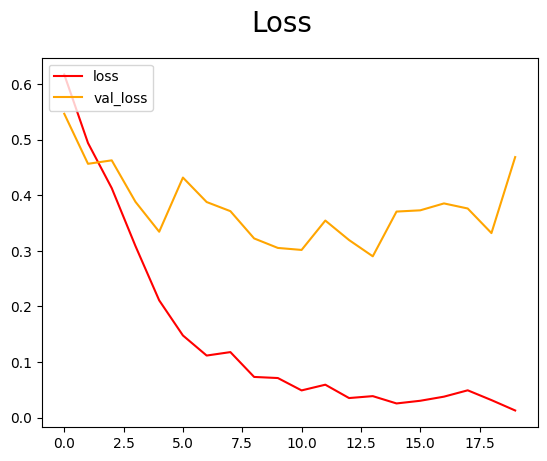

In [ ]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='red', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

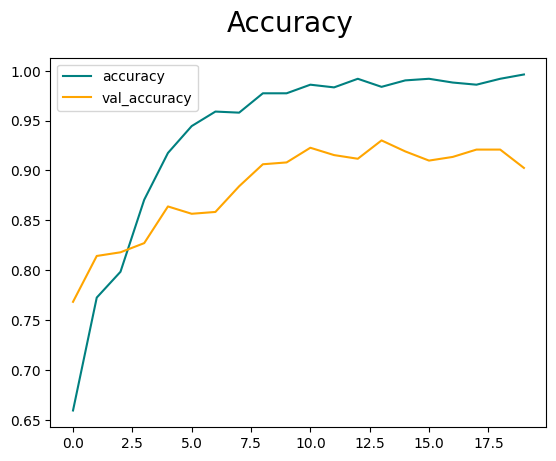

In [ ]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

In [ ]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy
precision_measure = Precision()
recall = Recall()
accuracy = BinaryAccuracy()

for batch in test.as_numpy_iterator():
    X, y = batch
    y_pred = cnn_model_improved.predict(X)
    precision_measure.update_state(y, y_pred)
    recall.update_state(y, y_pred)
    accuracy.update_state(y, y_pred)

1/1 [==============================] - 0s 447ms/step


In [ ]:
print(precision_measure.result().numpy(), recall.result().numpy(), accuracy.result().numpy())

0.8888889 0.88135594 0.8875
